# Seccion C

In [1]:
import pandas as pd

In [2]:
columns = list(range(7))
bm_df = pd.read_csv("bops_bm.csv", usecols=columns)
online_df = pd.read_csv("bops_online.csv", usecols= columns)
# Remove whitespaces in columns names
bm_df.columns = [col.strip() for col in bm_df.columns ]
online_df.columns = [col.strip() for col in online_df.columns ]
bm_df.astype({'sales': 'float32'})
online_df.astype({'sales': 'float32'})

,id (DMA),year,month,week,after,close,sales
0,1,2011,4,17,0,1,18564.0
1,1,2011,4,18,0,1,30883.0
2,1,2011,5,19,0,1,37425.0
3,1,2011,5,20,0,1,32563.0
4,1,2011,5,21,0,1,35773.0
...,...,...,...,...,...,...,...
10705,210,2012,2,10,1,0,9357.0
10706,210,2012,3,11,1,0,3013.0
10707,210,2012,3,12,1,0,3155.0
10708,210,2012,3,13,1,0,2925.0


## Dictionaires

    id (DMA): Designated Market Area (DMA) identification code
    year: Year
    month:Month number (January =1)
    week: Week number (first week of the year = 1)
    after: Equal to 1 if week is after introduction of BOPS; 0 otherwise
    close: Equal to 1 if week is DMA is within 50 miles of a store; 0 otherwise
    sales : Total online sales for the week for the DMA in dollars

    id (store):Store identification code
    year: Year
    month: Month (January = 1)
    week: Week (first week of the year = 1)
    usa: Equal to 1 if store is in the USA; 0 if it is a Canadian store
    after: Equal to 1 if week is after introduction of BOPS; 0 otherwise
    sales: Total B&M sales for the week for the store
    

## Let's start analyzing the brick and mortar sales (directly on store). we will compare the sales in canada vs the ones in the USA. In canada the BOMS has not been introduced.

In [27]:
canada_stores_df = bm_df.where(bm_df['usa']==0).dropna().drop(['usa','month','id (store)'], axis=1)
canada_stores_df = canada_stores_df.groupby(['year', 'week','after']).mean().reset_index()

In [28]:
usa_stores_df = bm_df.where(bm_df['usa']==1).dropna().drop(['usa','month','id (store)'], axis=1)
usa_stores_df = usa_stores_df.groupby(['year', 'week','after']).mean().reset_index()


In [5]:
#Get the index where it changes
index_bom = usa_stores_df[usa_stores_df['after']==1].iloc[0].name

## Lets try to do causal Impact

In [6]:
from causalimpact import CausalImpact

In [7]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima_process import arma_generate_sample
import matplotlib
import seaborn as sns
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (15, 6)

# x1 is the baseline, in this case Canada
x1 = canada_stores_df['sales']
# y is the series where the event happened, in this case the BOM
y = usa_stores_df['sales']

data = pd.DataFrame(np.array([y, x1]).T, columns=["y","x1"])

In [8]:
print(data.shape)
data.head()

(54, 2)


,y,x1
0,60573.955224,61335.588235
1,53481.582090,56111.941176
2,71665.746269,72194.764706
3,66949.791045,62477.941176
4,73991.388060,64729.294118


<AxesSubplot:>

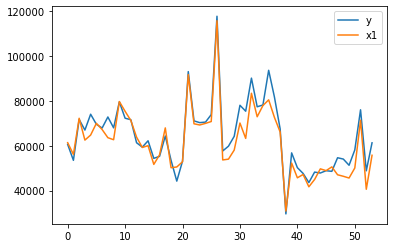

In [9]:
data.plot()

In [10]:
pre_period = [0,index_bom]
post_period = [index_bom+1,len(x1)-1]

In [11]:
impact = CausalImpact(data, pre_period, post_period)

In [12]:
impact.run()

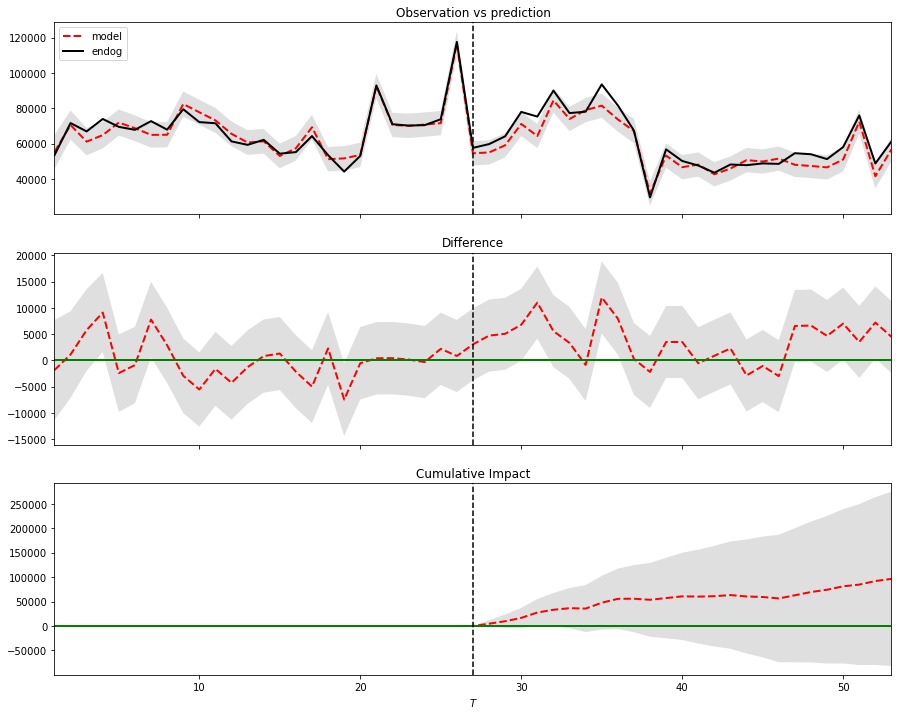

In [13]:
impact.plot()

In [14]:
impact.summary()

                        Average          Cumulative
Actual                    61190             1590948
Predicted                 57479             1494472
95% CI           [50614, 64344]  [1315985, 1672959]
                                                   
Absolute Effect            3710               96475
95% CI           [10575, -3154]    [274962, -82010]
                                                   
Relative Effect            6.5%                6.5%
95% CI           [18.4%, -5.5%]      [18.4%, -5.5%]


## Analyze the online sales with respect to the DMA, we will compare the average sales per week per DMA from the stores that are closer than 50 miles from the DMA to the ones that are further.

In [29]:
faraway_stores_df = online_df.where(online_df['close']==0).dropna().drop(['close','month','id (DMA)'], axis=1)
faraway_stores_df = faraway_stores_df.groupby(['year', 'week','after']).mean().reset_index()


In [30]:
close_stores_df = online_df.where(online_df['close']==1).dropna().drop(['close','month','id (DMA)'], axis=1)
close_stores_df = close_stores_df.groupby(['year', 'week','after']).mean().reset_index()


In [17]:
#Get the index where it changes
index_bom = close_stores_df[close_stores_df['after']==1].iloc[0].name

In [18]:
# x1 is the baseline, in this case far away stores
x1 = faraway_stores_df['sales']
# y is the series where the event happened and had an impact, in this case the close stores
y = close_stores_df['sales']

data = pd.DataFrame(np.array([y, x1]).T, columns=["y","x1"])

In [19]:
print(data.shape)
data.head()


(51, 2)


,y,x1
0,12575.445545,16158.366972
1,13280.435644,16914.449541
2,15655.049505,17632.587156
3,13609.257426,18530.128440
4,15908.227723,19518.568807


<AxesSubplot:>

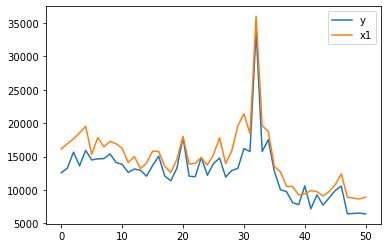

In [20]:
data.plot()

In [21]:
pre_period = [0,index_bom]
post_period = [index_bom+1,len(x1)-1]

In [22]:
impact2 = CausalImpact(data, pre_period, post_period)

In [23]:
impact2.run()

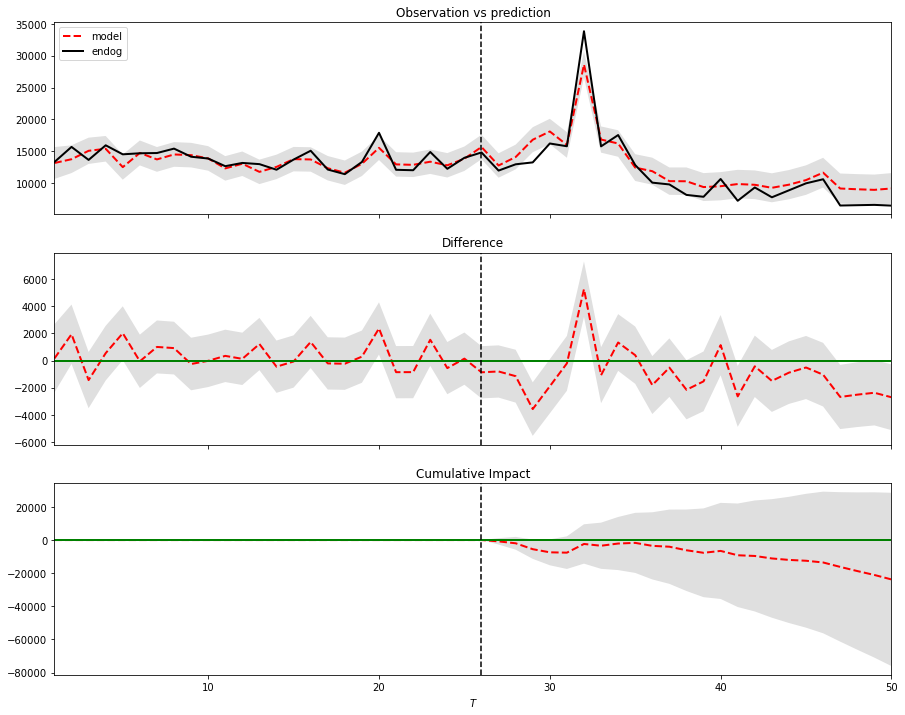

In [24]:
impact2.plot()

In [26]:
print(impact.summary())
print('\n')
print(impact2.summary())

                        Average          Cumulative
Actual                    61190             1590948
Predicted                 57479             1494472
95% CI           [50614, 64344]  [1315985, 1672959]
                                                   
Absolute Effect            3710               96475
95% CI           [10575, -3154]    [274962, -82010]
                                                   
Relative Effect            6.5%                6.5%
95% CI           [18.4%, -5.5%]      [18.4%, -5.5%]
None


                        Average        Cumulative
Actual                    11483            275605
Predicted                 12474            299382
95% CI           [10293, 14654]  [247054, 351710]
                                                 
Absolute Effect            -990            -23776
95% CI            [1189, -3171]   [28551, -76105]
                                                 
Relative Effect           -7.9%             -7.9%
95% CI           [9.5%,

# Answers

According to the first causal impact analysis, the BOPS had a small positive impact on the average sales from the brick and mortar stores. A 6.5% increase in their average sales per week per store. The part that is concerning is the fact that the confidence intervals are very wide and contain zero, this means that the model is really uncertain and that there may have been any significant impact due to the BOP.

The second causal impact analysis tell us that the BOPS had a negative impact on the average sales per DMA. An almost 8% decrease in sales, but in the same way as the previous analysis it may be not related to the BOPS.

In my opinion they shouldn't expand to Canada yet, the results show that something external may have happened that did not allow to measure the impact of the BOPS. They should wait and see if the trend changes to conclude properly.